In [128]:
import importlib
import utilities.functions as functions
import pandas as pd
importlib.reload(functions)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json



from utilities.functions import (
    summary,
    matriz_migracao,
    save_parquet,
    gerar_resumo_decis,
    resumo_coorte_ativa

)

In [129]:
df_pub_u = pd.read_parquet("../dados/gold/df_pub_un.parquet")

In [130]:
df_pub_u.head()

,customer_id,is_target,order_created_month,num_pedidos_mes,num_pedidos_hist,total_amount_mes,ticket_medio
0,ffffeda85b466b48195c356f8b97f21d0b23958d5815fc...,target,12,1,2,167.0,167.0
1,ffffeda85b466b48195c356f8b97f21d0b23958d5815fc...,target,1,1,2,167.0,167.0
2,ffffe95dc11472a22c46b6d5cdc5c14cf40e0c88a601e0...,target,12,2,4,209.0,104.5
3,ffffe95dc11472a22c46b6d5cdc5c14cf40e0c88a601e0...,target,1,2,4,209.0,104.5
4,ffffe50aaaed54af0eb463fcc6761b0e17a1d1cdd6b8e1...,control,12,1,2,55.6,55.6


Sumarizacao na visao cliente - mes

In [131]:
summary(df_pub_u)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,1360532,806156,ffffeda85b466b48195c356f8b97f21d0b23958d5815fc...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_target,1360532,2,target,758662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_created_month,1360532.0,NaN,NaN,NaN,5.48217,5.405002,1.0,1.0,1.0,12.0,12.0
num_pedidos_mes,1360532.0,NaN,NaN,NaN,2.690896,3.246342,1.0,1.0,2.0,3.0,157.0
num_pedidos_hist,1360532.0,NaN,NaN,NaN,5.11179,6.023283,1.0,2.0,3.0,6.0,239.0
total_amount_mes,1360532.0,NaN,NaN,NaN,128.64053,257.078642,0.0,39.0,68.8,142.7,140338.9
ticket_medio,1360532.0,NaN,NaN,NaN,47.96733,94.513167,0.0,29.3,40.9,56.9,70169.45


Clientes mes x target

In [132]:
clientes_mes = (df_pub_u.groupby(['order_created_month', 'is_target'])
              ['customer_id']
              .nunique()
              .reset_index(name='numero_clientes_distintos'))
clientes_mes

,order_created_month,is_target,numero_clientes_distintos
0,1,control,360413
1,1,target,445743
2,12,control,241457
3,12,target,312919


 Matriz de migracao - cliente

In [133]:
matriz_migracao(df_pub_u,mes_0=12,mes_1=1)

,mes_12,mes_1,is_target,total_clientes
0,0,1,control,118956
1,0,1,target,132824
2,1,1,control,241457
3,1,1,target,312919


Dado o montante de clientes novos em janeiro a analise sera feita basead em cliente ambos os meses e cliente somente em janeiro

In [136]:
id_both_monht=df_pub_u[df_pub_u['order_created_month']==12]['customer_id'].unique()
publico_janeiro_dezembro = df_pub_u[df_pub_u['customer_id'].isin(id_both_monht)].reset_index(drop=True)
publico_janeiro = df_pub_u[~df_pub_u['customer_id'].isin(id_both_monht)].reset_index(drop=True)

In [137]:
publico_janeiro.head()

,customer_id,is_target,order_created_month,num_pedidos_mes,num_pedidos_hist,total_amount_mes,ticket_medio
0,ffff5c20451392675218c9656de13e461290d8813325eb...,target,1,2,2,34.00,17.000
1,ffff5c13d03e6607e659bb92b3c42622aa535952035971...,target,1,1,1,39.80,39.800
2,ffff46e59e22a70f04e352af413552d6812ac72a53eb13...,control,1,1,1,7.00,7.000
3,ffff38c26c3355cbccfc4256b46c82d46a59b4a4bd10b3...,control,1,2,2,93.00,46.500
4,fffee453ae3920b3604fcdd511bb194262247a550d2034...,target,1,4,4,215.02,53.755


In [138]:
save_parquet(publico_janeiro_dezembro, "gold", "publico_janeiro_dezembro.parquet")


PosixPath('/Users/maceli/ifood_cs/dados/gold/publico_janeiro_dezembro.parquet')

Pedidos por mes - target

In [139]:
pedidos_total = (
    publico_janeiro_dezembro.groupby(['is_target','order_created_month'])['num_pedidos_mes']
      .sum()
      .reset_index(name='numero_de_pedidos_total')
)

pedidos_total

,is_target,order_created_month,numero_de_pedidos_total
0,control,1,844890
1,control,12,514666
2,target,1,1214354
3,target,12,719794


Distruibuicao do total amount por mes

In [140]:
df_stats_mes = publico_janeiro_dezembro.groupby(['order_created_month', 'is_target'])['total_amount_mes'].agg(
    Média=('mean'),
    Mediana=('median'),
    Mínimo=('min'),
    Máximo=('max'),
    Desvio_Padrão=('std')
).round(2)
df_stats_mes

Média  Mediana  Mínimo     Máximo  \
order_created_month is_target                                       
1                   control    168.02    88.10     0.0  140338.90   
                    target     185.91   104.90     0.0    9813.87   
12                  control    102.01    59.88     0.0  140338.90   
                    target     109.50    65.50     0.0    7409.67   

                               Desvio_Padrão  
order_created_month is_target                 
1                   control           372.96  
                    target            252.94  
12                  control           314.40  
                    target            137.72

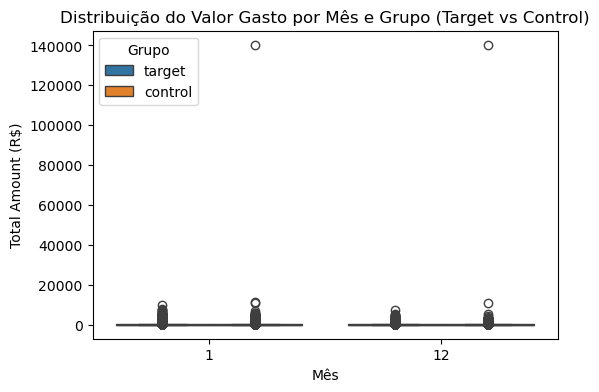

In [141]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=publico_janeiro_dezembro,
    y='total_amount_mes',
    x='order_created_month',  
    hue='is_target',          
    
)

plt.title('Distribuição do Valor Gasto por Mês e Grupo (Target vs Control)')
plt.ylabel('Total Amount (R$)')
plt.xlabel('Mês')
plt.legend(title='Grupo')
plt.show()

Observa-se grande numero de outliers, verificar a distribuicao removendo outliers.

In [142]:
publico_janeiro_dezembro['total_amount_mes'].describe().round(2)


count    1108752.00
mean         142.18
std          276.71
min            0.00
25%           41.10
50%           76.90
75%          161.60
max       140338.90
Name: total_amount_mes, dtype: float64

<Axes: >

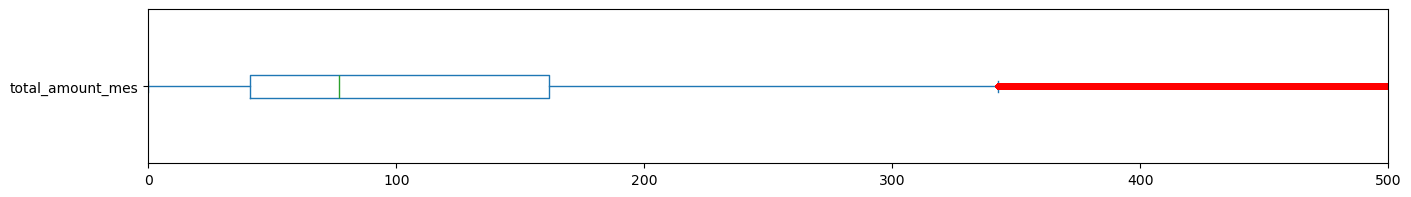

In [143]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
publico_janeiro_dezembro['total_amount_mes'].plot(kind='box', xlim=(0, 500), vert=False, flierprops=red_square, figsize=(16,2))

In [144]:
distance = 1.5 * (np.nanpercentile(publico_janeiro_dezembro['total_amount_mes'], 75) - np.nanpercentile(publico_janeiro_dezembro['total_amount_mes'], 25))
lim_sup=distance + np.nanpercentile(publico_janeiro_dezembro['total_amount_mes'], 75)

In [145]:
pb_drop = publico_janeiro_dezembro.drop(
    publico_janeiro_dezembro[
        (publico_janeiro_dezembro['total_amount_mes'] == 0) |
        (publico_janeiro_dezembro['total_amount_mes'] > lim_sup)
    ].index,
    axis=0
)

In [146]:
pb_drop['total_amount_mes'].describe().round(2)

count    1010769.00
mean          95.05
std           75.14
min            0.01
25%           39.00
50%           68.20
75%          129.90
max          342.35
Name: total_amount_mes, dtype: float64

<Axes: >

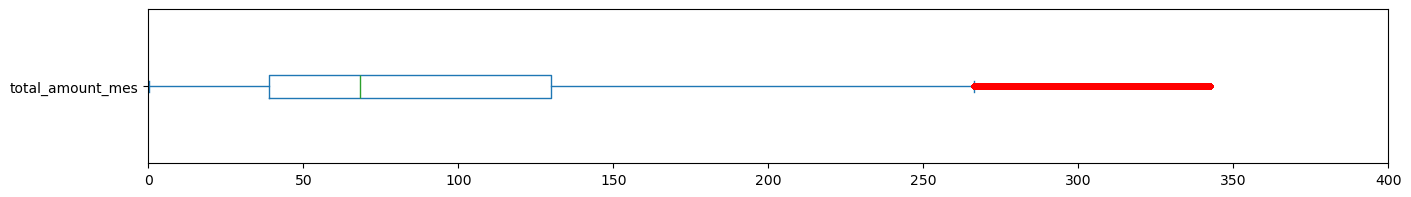

In [147]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
pb_drop['total_amount_mes'].plot(kind='box', xlim=(0, 400), vert=False, flierprops=red_square, figsize=(16,2))

In [148]:
df_decil,decil_dict=cria_base_decil_wide(publico_janeiro_dezembro,
    mes_0=12,  
    mes_1=1,  
    col_cliente="customer_id",
    col_mes="order_created_month",
    col_pedidos="num_pedidos_mes",
    col_valor="total_amount_mes",
    col_target="is_target",  
    n_decis=10,
    prefixo_decil="decil",
    prefixo_pedidos="num_pedidos_mes",
    prefixo_valor="total_amount_mes"
)

/Users/maceli/ifood_cs/code/utilities/functions.py:606: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_m0.groupby(col_decil_m0)[col_valor]


In [149]:
df_decil.head()

,customer_id,is_target,decil_1,decil_12,num_pedidos_mes_1,num_pedidos_mes_12,total_amount_mes_1,total_amount_mes_12
0,000009e29b12d8c5b9c9579e21384320c2df3bd935f19e...,control,decil 10,decil 7,8,2,273.00,100.00
1,000021924bf8192f64a7cc17ce7c0bc511cba907308f80...,target,decil 9,decil 8,3,2,173.90,119.90
2,000022ced2f3aa411b66ac41167b272ae528c4acdffeeb...,target,decil 6,decil 6,2,2,68.65,68.65
3,000032b594523c3f8868edee4f1577b157e115cd01ab31...,control,decil 7,decil 7,1,1,88.80,88.80
4,0000bb10fb47a1d6b2d73754ef383950ef536c77d07212...,control,decil 9,decil 9,2,2,188.19,188.19


In [150]:
save_parquet(df_decil, "../dados/gold", "df_decil.parquet")

PosixPath('/Users/maceli/ifood_cs/dados/../dados/gold/df_decil.parquet')

In [151]:

decil_dict_json = {k: list(v) for k, v in decil_dict.items()}

with open('../dados/gold/decil_dictionary.json', 'w') as f:
    json.dump(decil_dict_json, f, indent=2)


In [152]:
decil_summary=gerar_resumo_decis(df_decil)
decil_summary

,decil_12,decil_1,is_target,total_clientes,avg_amount_12,avg_amount_1,avg_pedidos_12,avg_pedidos_1,ticket_medio_12,ticket_medio_1
0,decil 1,decil 1,control,18701,18.22,18.31,1.01,1.02,18.03,17.96
1,decil 1,decil 1,target,18754,18.23,18.35,1.02,1.03,17.90,17.81
2,decil 1,decil 10,control,191,19.76,308.63,1.01,7.35,19.55,42.02
3,decil 1,decil 10,target,310,19.69,315.48,1.01,7.34,19.44,42.97
4,decil 1,decil 2,control,488,14.42,29.52,1.03,2.09,13.99,14.15
...,...,...,...,...,...,...,...,...,...,...
105,decil 8,decil 9,target,9304,122.82,185.27,2.86,4.50,42.88,41.15
106,decil 9,decil 10,control,13307,184.31,371.63,3.88,7.64,47.50,48.61
107,decil 9,decil 10,target,19800,184.49,374.09,3.91,7.74,47.22,48.35
108,decil 9,decil 9,control,9264,173.27,183.72,3.06,3.36,56.68,54.61


In [153]:
decil_summary.to_csv('../Resultados/decil_summary.csv', index=False)


Numero de pedidos em Janeiro e Dezembro para o quem esteve em ambos meses

In [154]:

pedidos_hist=resumo_coorte_ativa(publico_janeiro_dezembro,12)
pedidos_hist

,is_target,Total_Pedidos_Janeiro,Total_Pedidos_Dezembro,Total_Clientes
0,control,1,1,97595
1,control,2,1,22495
2,control,2,2,19972
3,control,3,1,10227
4,control,3,2,9732
...,...,...,...,...
1456,target,87,40,1
1457,target,92,39,1
1458,target,101,49,1
1459,target,105,32,1


In [155]:
pedidos_hist.to_csv('../Resultados/pedidos_hist.csv', index=False)